In [1]:
import pandas as pd
import numpy as np
from random import randint
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pyplot import figure
import math
import itertools
from prettytable import PrettyTable
from matplotlib.colors import ListedColormap
import networkx as nx

In [2]:
def read_maf(maf_file_name):
    maf_fields = ["Hugo_Symbol", "Tumor_Sample_Barcode"]
    maf = pd.read_csv(maf_file_name, sep='\t', usecols=maf_fields, comment='#')
    return maf

def get_benchmark_genes_original():
    benchmark_file_name = "./benchmarks/scores_benchmarks_genes.tsv"
    benchmark_df = pd.read_csv(benchmark_file_name, sep='\t', usecols=["gene", "general_driver"])
    # getting only genes in some benchmark, excluding only gene in possible false positives:
    benchmark_df = benchmark_df[benchmark_df["general_driver"] >= 0]
    benchmark_driver_genes = list(benchmark_df["gene"])
    return benchmark_driver_genes

def get_benchmark_genes():
    benchmark_file_name = "./benchmarks/scores_benchmarks_genes.tsv"
    benchmark_df = pd.read_csv(benchmark_file_name, sep='\t')
    benchmark_df = benchmark_df.set_index("gene")

    driver_benchmark = set(benchmark_df[benchmark_df["ncg"] > 0].index) | set(benchmark_df[benchmark_df["cgc"] > 0].index) | set(benchmark_df[benchmark_df["intogen"] > 0].index) | set(benchmark_df[benchmark_df["bailey"] > 0].index)
    false_positive_benchmark = set(benchmark_df[benchmark_df["ncg_possible_false_positive"] > 0].index)
    driver_benchmark = driver_benchmark - false_positive_benchmark
    return list(driver_benchmark)

'''
Input: a CaGeDINN file name with result
Output: a list with priorited genes
'''
def get_gene_list(results_file_name, N):
    results_df = pd.read_csv(results_file_name, sep='\t', usecols=["gene"])
    genes_result = list(results_df["gene"])
    
    return genes_result[:N]

def get_genes_by_frequency(results_file_name, N):
    results_df = pd.read_csv(results_file_name, comment='#', sep='\t', usecols=["gene", "mutated_samples"])
    results_df = results_df.sort_values(by=["mutated_samples"], ascending=False)
    return list(results_df["gene"])[:N]

def get_genes_by_weighted_frequency(results_file_name, N):
    results_df = pd.read_csv(results_file_name, comment='#', sep='\t', usecols=["gene"])
    return list(results_df["gene"])[:N]

def get_genes_by_neighbors_score(results_file_name, N):
    results_df = pd.read_csv(results_file_name, comment='#', sep='\t', usecols=["gene", "score_from_neighbors"])
    results_df = results_df.sort_values(by=["score_from_neighbors"], ascending=False)
    return list(results_df["gene"])[:N]
    

# Results of nCOP
def get_gene_list_nCOP(results_file_name, N):
    results_df = pd.read_csv(results_file_name, sep = ' ', usecols=[0], names=["gene"])
    return list(results_df["gene"])[:N]

# Results of MutSigCV
def get_gene_list_mutsigcv(results_file_name, N):
    results_df = pd.read_csv(results_file_name, sep = '\t', usecols=["gene"])
    return list(results_df["gene"])[:N]

# Results of MUFFINN
def get_gene_list_muffinn(results_file_name, N):
    results_df = pd.read_csv(results_file_name, sep = '\t', usecols=["Gene_Symbol"])
    return list(results_df["Gene_Symbol"])[:N]


'''
Output: precision
'''
def get_precision(genes_result, benchmark_driver_genes):
    into_driver_benchmark = 0
    precision_list = []

    i = 0
    for gene in genes_result:
        if gene in benchmark_driver_genes:
            into_driver_benchmark = into_driver_benchmark + 1
        i = i + 1
        precision_list.append(into_driver_benchmark / i)

    return precision_list

def get_dcg(gene_results, benchmark_values):
    dcg_list = []
    dcg = 0
    
    pos = 1
    for gene in gene_results:
        gene_value = benchmark_values[gene]
    
        dcg = dcg + (gene_value / math.log(pos + 1, 2))

        dcg_list.append(dcg)
        pos = pos + 1
    return dcg_list

def get_heatmap_df(cancer_type, gene_results, benchmark_df):
    d = {}
    for gene in gene_results:
        benchmark_in = [0, 0, 0, 0, 0, 0]
        if gene in benchmark_df.index:
            if benchmark_df.loc[gene]["ncg"] > 0:
                benchmark_in[0] = 1
            if benchmark_df.loc[gene]["cgc"] > 0:
                benchmark_in[1] = 2
            if benchmark_df.loc[gene]["intogen"] > 0:
                benchmark_in[2] = 3
            if benchmark_df.loc[gene]["bailey"] > 0:
                benchmark_in[3] = 4
            specific_driver_column = "intogen_" + cancer_type
            if benchmark_df.loc[gene][specific_driver_column] > 0:
                benchmark_in[4] = 5
            if benchmark_df.loc[gene]["ncg_possible_false_positive"] > 0:
                benchmark_in[5] = 6
        d[gene] = benchmark_in
        
    df = pd.DataFrame(data=d, index=["NCG", "CGC", "intOGen", "Bailey 2018", "Specific", "NCG Possible False Positive"])
    return df

In [3]:
def generate_boxplot_precision(all_results, benchmark_driver_genes, N, tendency):
    number_of_columns = 3
    number_of_rows = math.ceil(len(all_results)/number_of_columns)
    fig = plt.figure(figsize=(5*number_of_columns, 4*number_of_rows))
    position = 1
    for cancer_type in all_results:
        data = []
        methods = []
        ax = plt.subplot(number_of_rows, number_of_columns, position)
        median = []
        mean = []
        ax_x_list = []
        ax_x = 1
        for result_name in all_results[cancer_type]:
            gene_results = all_results[cancer_type][result_name]
            precision_list = get_precision(gene_results, benchmark_driver_genes)
            data.append(precision_list)
            methods.append(result_name)
            
            median.append(np.median(precision_list))
            mean.append(np.mean(precision_list))
            ax_x_list.append(ax_x)
            ax_x = ax_x + 1

        ax.set_title(cancer_type)
        ax.boxplot(data, labels=methods, showfliers=False)
        if tendency:
            ax.plot(ax_x_list, median, "-o", label="Median", lw=3.0)
            ax.plot(ax_x_list, mean, "-x", label="Mean", lw=3.0)
        
        if position == 1:
            ax.legend(loc="upper right")
        if position >= 4:
            ax.set_xlabel("Hyperparameter value")
        if position == 1 or position == 4:
            ax.set_ylabel("Precision")
        position = position + 1
        
    fig.tight_layout(h_pad=1.5, w_pad=1.0)
    return fig
    
def generate_boxplot_dcg(all_results, N, tendency):
    number_of_columns = 3
    number_of_rows = math.ceil(len(all_results)/number_of_columns)
    fig = plt.figure(figsize=(5*number_of_columns, 4*number_of_rows))
    position = 1
    for cancer_type in all_results:
        benchmark_file_name = "./benchmarks/scores_benchmarks_genes.tsv"
        specific_driver_column = "specific_driver_" + cancer_type
        benchmark_df = pd.read_csv(benchmark_file_name, sep='\t', usecols=["gene", specific_driver_column])

        data = []
        methods = []
        ax = plt.subplot(number_of_rows, number_of_columns, position)
        
        median = []
        mean = []
        ax_x_list = []
        ax_x = 1

        for result_name in all_results[cancer_type]:
            gene_results = all_results[cancer_type][result_name]

            benchmark_df_gene_results = benchmark_df[benchmark_df["gene"].isin(gene_results)]

            genes_in_benchmark = list(benchmark_df_gene_results["gene"])
            genes_not_in_benchmark = [[gene, 0] for gene in gene_results if gene not in genes_in_benchmark]

            benchmark_df_gene_results = benchmark_df_gene_results.append(pd.DataFrame(genes_not_in_benchmark, columns=["gene", specific_driver_column]), ignore_index=True)

            benchmark_values = benchmark_df_gene_results.set_index("gene")[specific_driver_column].to_dict()

            dcg_list = get_dcg(gene_results, benchmark_values)

            data.append(dcg_list)
            methods.append(result_name)
            
            median.append(np.median(dcg_list))
            mean.append(np.mean(dcg_list))
            ax_x_list.append(ax_x)
            ax_x = ax_x + 1

        ax.set_title(cancer_type)
        ax.boxplot(data, labels=methods, showfliers=False)
        if tendency:
            ax.plot(ax_x_list, median, "-o", label="Median", lw=3.0)
            ax.plot(ax_x_list, mean, "-x", label="Mean", lw=3.0)

        if position == 1:
            ax.legend(loc="upper right")
        if position >= 4:
            ax.set_xlabel("Hyperparameter value")
        if position == 1 or position == 4:
            ax.set_ylabel("DCG")
        position = position + 1

    fig.tight_layout(h_pad=1.5, w_pad=1.0)
    return fig

# Comparisons

PRECISION:


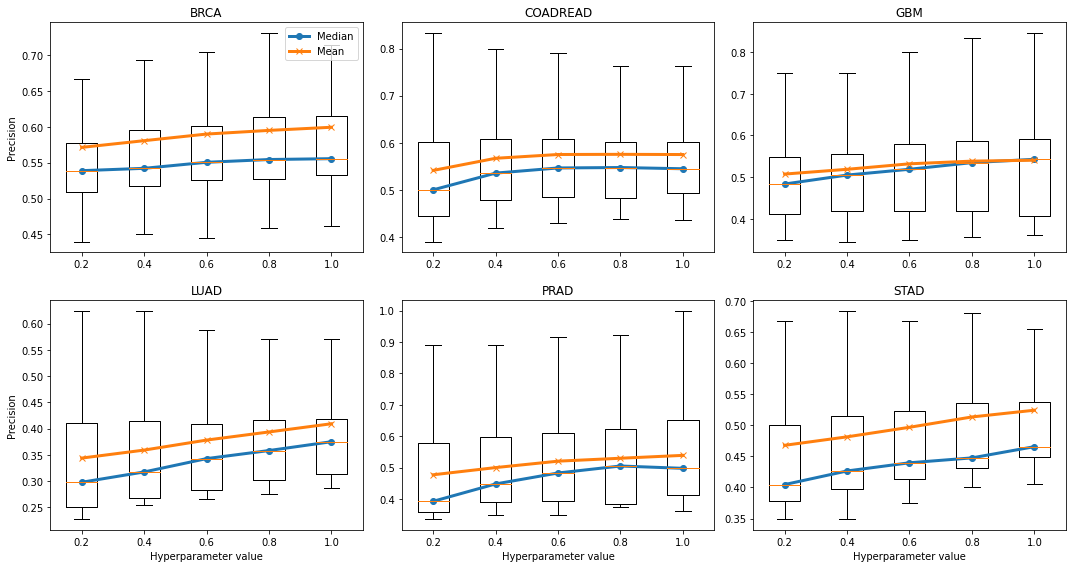


DCG:


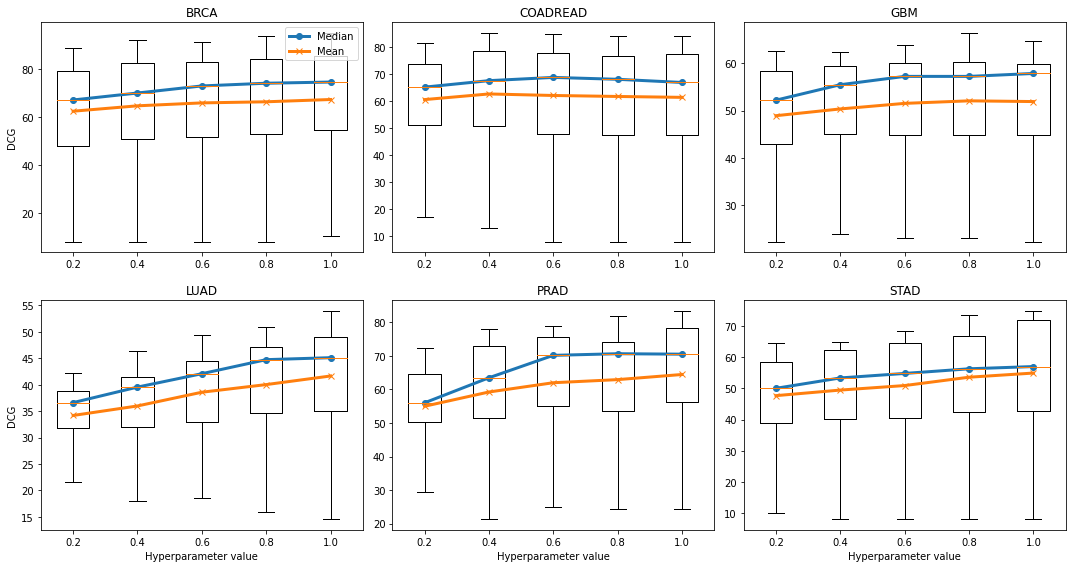

In [4]:
# influence of weigths on group 1 of mutations
# - Group 1: Nonsense_Mutation, Frame_Shift_Ins, Frame_Shift_Del

N = 200
benchmark_driver_genes = get_benchmark_genes()
cancer_type_list = ["BRCA", "COADREAD", "GBM", "LUAD", "PRAD", "STAD"]

all_results = {} 
for cancer_type in cancer_type_list:
    all_results_cancer_type = {}
    
    parameters_list = ["0.2_0.4_0.2", "0.4_0.4_0.2", "0.6_0.4_0.2", "0.8_0.4_0.2", "1.0_0.4_0.2"]
    
    for p in parameters_list:
        result_file_name = "./results_for_comparisons/hyperparameter_variation/" + cancer_type + "_SNV_InDel_preprocessed_" + p + ".score.mutatedGenes"
        result_gene_list = get_gene_list(result_file_name, N)
        value = p.split("_")[0]
        all_results_cancer_type[value] = result_gene_list

    all_results[cancer_type] = all_results_cancer_type

print("PRECISION:")    
fig = generate_boxplot_precision(all_results, benchmark_driver_genes, N, True)
output_file_name =  "hyperparameter_variation_precision_g1.png"
fig.savefig("/home/cutigi/Dropbox/Doutorado/Tese/images/results/" + output_file_name, format='png', dpi=150, bbox_inches='tight')
plt.show()

print("\nDCG:")
fig = generate_boxplot_dcg(all_results, N, True)
output_file_name =  "hyperparameter_variation_dcg_g1.png"
fig.savefig("/home/cutigi/Dropbox/Doutorado/Tese/images/results/" + output_file_name, format='png', dpi=150, bbox_inches='tight')
plt.show()

PRECISION:


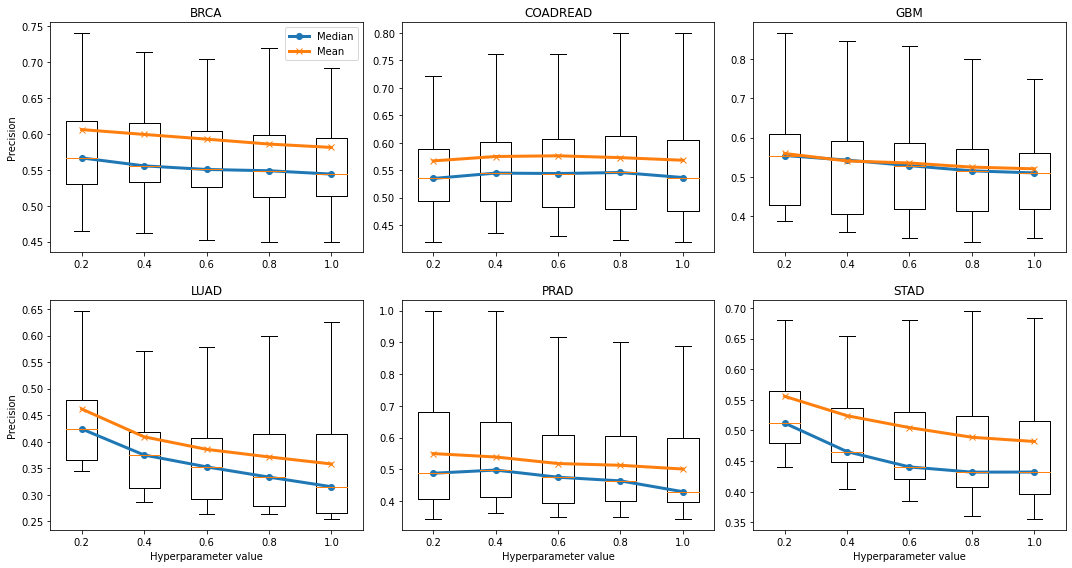


DCG:


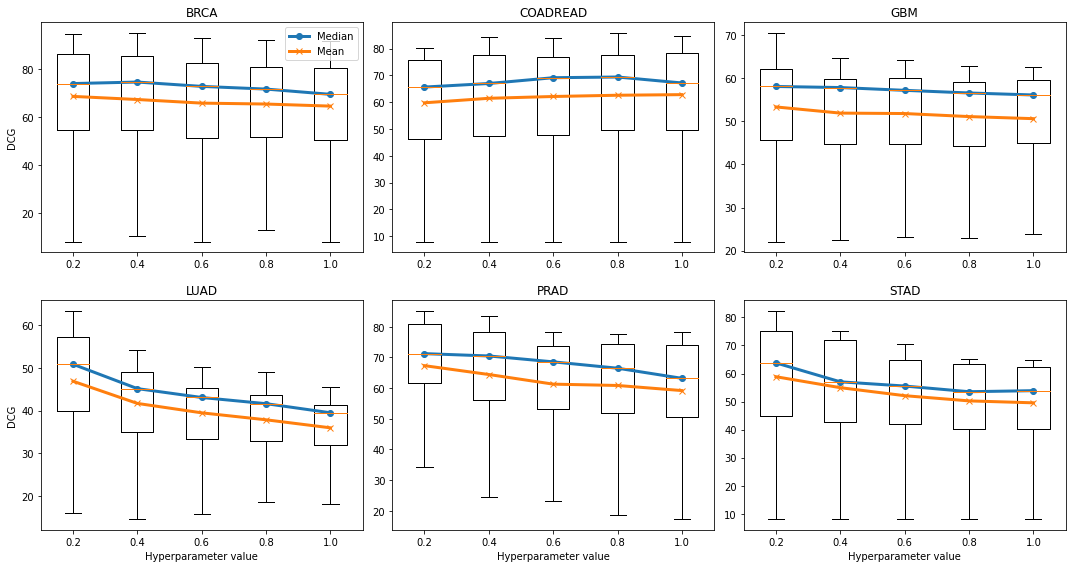

In [5]:
# influence of weigths on group 1 of mutations
# - Group 2:

N = 200
benchmark_driver_genes = get_benchmark_genes()
cancer_type_list = ["BRCA", "COADREAD", "GBM", "LUAD", "PRAD", "STAD"]

all_results = {} 
for cancer_type in cancer_type_list:
    all_results_cancer_type = {}
    
    parameters_list = ["1.0_0.2_0.2", "1.0_0.4_0.2", "1.0_0.6_0.2", "1.0_0.8_0.2", "1.0_1.0_0.2"]
    
    for p in parameters_list:
        result_file_name = "./results_for_comparisons/hyperparameter_variation/" + cancer_type + "_SNV_InDel_preprocessed_" + p + ".score.mutatedGenes"
        result_gene_list = get_gene_list(result_file_name, N)
        value = p.split("_")[1]
        all_results_cancer_type[value] = result_gene_list
    

    all_results[cancer_type] = all_results_cancer_type

print("PRECISION:")    
fig = generate_boxplot_precision(all_results, benchmark_driver_genes, N, True)
output_file_name =  "hyperparameter_variation_precision_g2.png"
fig.savefig("/home/cutigi/Dropbox/Doutorado/Tese/images/results/" + output_file_name, format='png', dpi=150, bbox_inches='tight')
plt.show()

print("\nDCG:")
fig = generate_boxplot_dcg(all_results, N, True)
output_file_name =  "hyperparameter_variation_dcg_g2.png"
fig.savefig("/home/cutigi/Dropbox/Doutorado/Tese/images/results/" + output_file_name, format='png', dpi=150, bbox_inches='tight')
plt.show()

PRECISION:


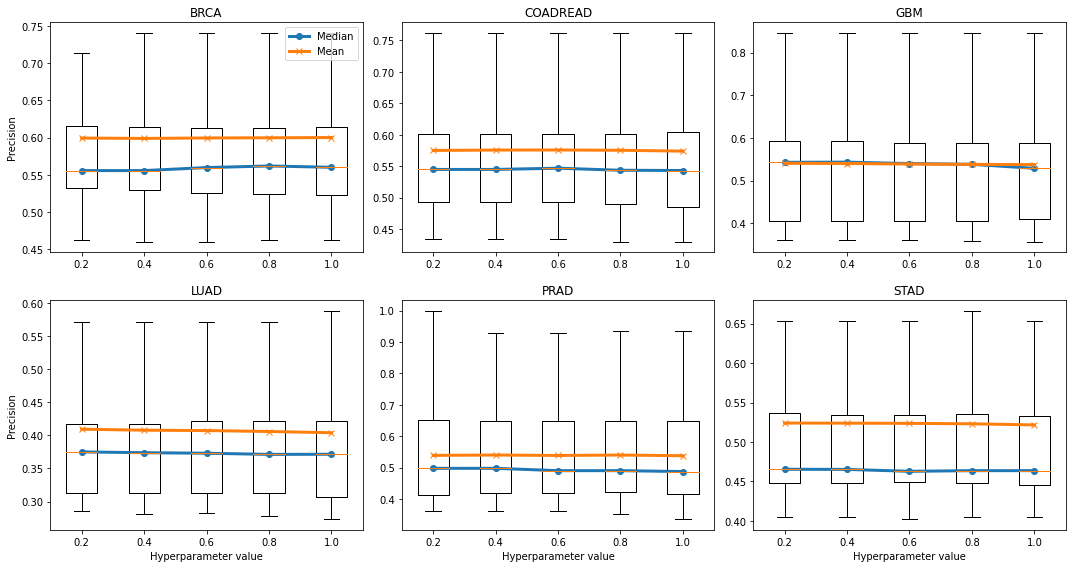


DCG:


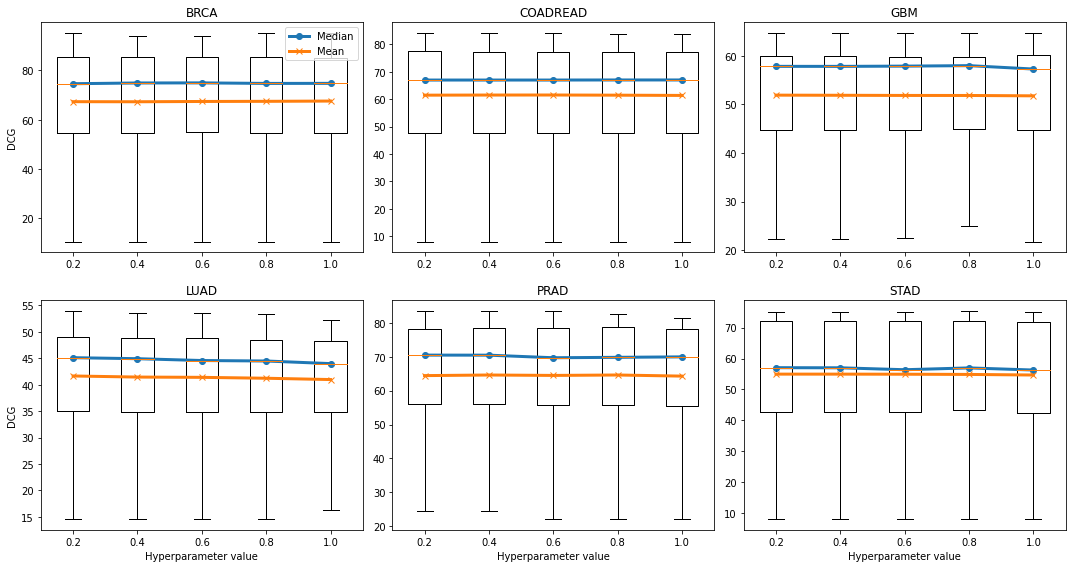

In [6]:
# influence of weigths on group 1 of mutations
# - Group 3:

N = 200
benchmark_driver_genes = get_benchmark_genes()
cancer_type_list = ["BRCA", "COADREAD", "GBM", "LUAD", "PRAD", "STAD"]

all_results = {} 
for cancer_type in cancer_type_list:
    all_results_cancer_type = {}
    
    parameters_list = ["1.0_0.4_0.2", "1.0_0.4_0.4", "1.0_0.4_0.6", "1.0_0.4_0.8", "1.0_0.4_1.0"]
    
    for p in parameters_list:
        result_file_name = "./results_for_comparisons/hyperparameter_variation/" + cancer_type + "_SNV_InDel_preprocessed_" + p + ".score.mutatedGenes"
        result_gene_list = get_gene_list(result_file_name, N)
        value = p.split("_")[2]
        all_results_cancer_type[value] = result_gene_list
    

    all_results[cancer_type] = all_results_cancer_type

print("PRECISION:")    
fig = generate_boxplot_precision(all_results, benchmark_driver_genes, N, True)
output_file_name =  "hyperparameter_variation_precision_g3.png"
fig.savefig("/home/cutigi/Dropbox/Doutorado/Tese/images/results/" + output_file_name, format='png', dpi=150, bbox_inches='tight')
plt.show()

print("\nDCG:")
fig = generate_boxplot_dcg(all_results, N, True)
output_file_name =  "hyperparameter_variation_dcg_g3.png"
fig.savefig("/home/cutigi/Dropbox/Doutorado/Tese/images/results/" + output_file_name, format='png', dpi=150, bbox_inches='tight')
plt.show()

# Network influence analysis

In [4]:
gene_network_file_names = ["geneNetwork_simple1", "geneNetwork_simple2",
                           "geneNetwork_simple3", "geneNetwork_simple4"]

gene_network_file_names = ["eReactome", "eHINT",
                           "eHuRI", "eHPRD"]

gene_network_file_names = ["eReactome", "eHPRD"]



edge_list_all_networks = {}
node_list_all_networks = {}
for gene_network_file_name in gene_network_file_names:
    gene_network_nx = nx.read_edgelist("../input/networks/" + gene_network_file_name + ".txt", delimiter='\t')
    gene_network_nx = gene_network_nx.to_directed()
    edge_list_all_networks[gene_network_file_name] = set(gene_network_nx.edges)
    node_list_all_networks[gene_network_file_name] = set(gene_network_nx.nodes)
    print(gene_network_file_name)

eReactome
eHPRD


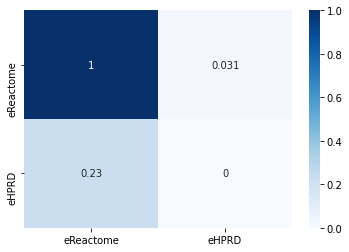

In [5]:
n_rows = len(list(edge_list_all_networks))
n_cols = n_rows
heatmap_node = pd.DataFrame(np.zeros((n_rows, n_cols)), index=list(edge_list_all_networks), columns=list(edge_list_all_networks))
heatmap_edge = pd.DataFrame(np.zeros((n_rows, n_cols)), index=list(edge_list_all_networks), columns=list(edge_list_all_networks))


for net1, net2 in list(itertools.combinations(list(edge_list_all_networks), 2)):
    s1 = node_list_all_networks[net1]
    s2 = node_list_all_networks[net2]    
    heatmap_node.loc[net1, net2] = float(len(s1.intersection(s2)) / len(s1))
    heatmap_node.loc[net2, net1] = float(len(s1.intersection(s2)) / len(s2))
    heatmap_node.loc[net1, net1] = 1
    heatmap_node.loc[net2, net2] = 1
    
    
    s1 = edge_list_all_networks[net1]
    s2 = edge_list_all_networks[net2]
    heatmap_edge.loc[net1, net2] = float(len(s1.intersection(s2)) / len(s1))
    heatmap_edge.loc[net2, net1] = float(len(s1.intersection(s2)) / len(s2))
    heatmap_edge.loc[net1, net1] = 1
    heatmap_node.loc[net2, net2] = 1
       
sns.heatmap(heatmap_edge, annot=True, cmap="Blues")
#sns.heatmap(heatmap_node, annot=True, cmap="Blues")

PRECISION:


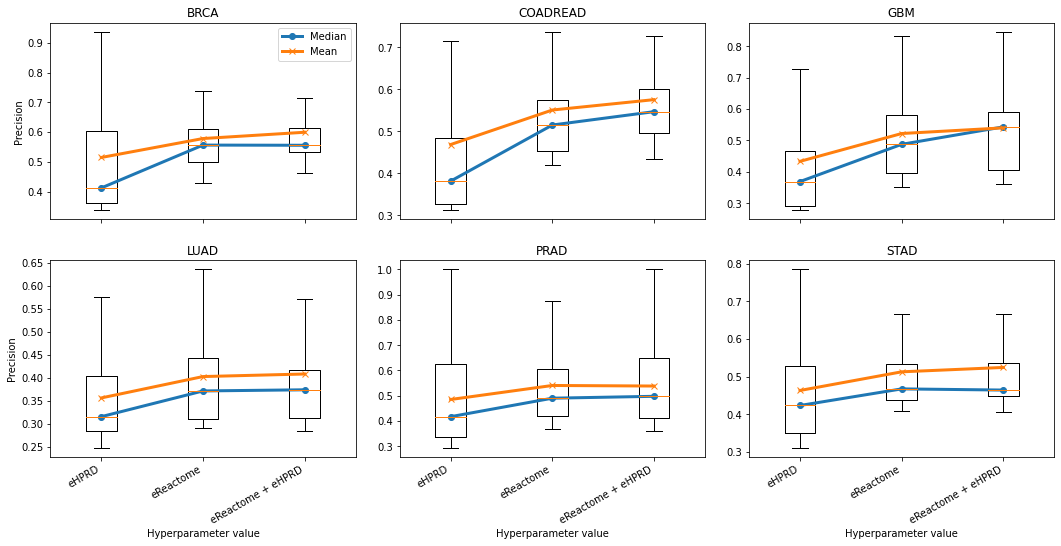


DCG:


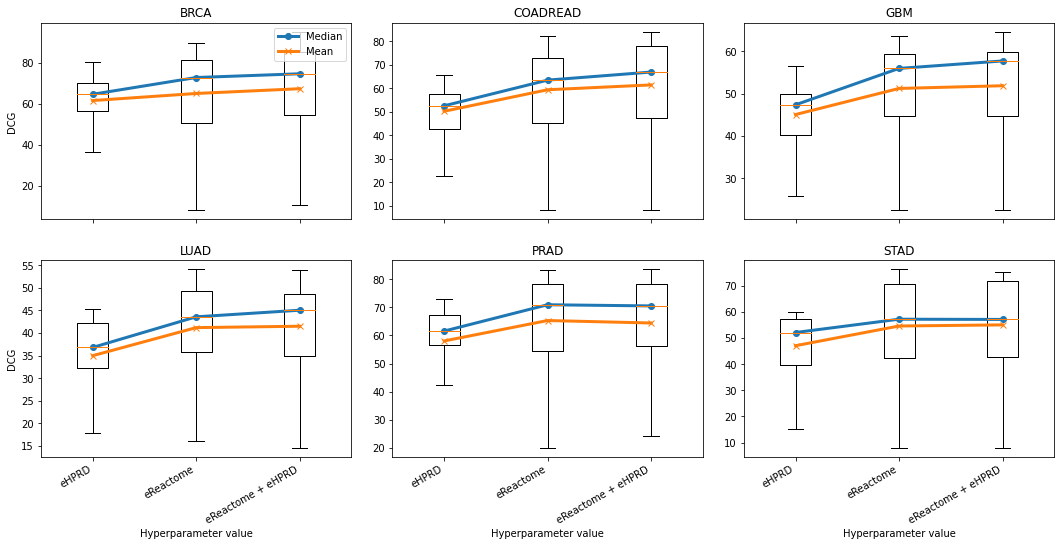

In [13]:
N = 200
benchmark_driver_genes = get_benchmark_genes()
cancer_type_list = ["BRCA", "COADREAD", "GBM", "LUAD", "PRAD", "STAD"]



all_results = {} 
for cancer_type in cancer_type_list:
    all_results_cancer_type = {}

    networks_list = ["eHPRD", "eReactome", "_eReactome_eHPRD"]


    
    for p in networks_list:
        result_file_name = "./results_for_comparisons/networks_results/" + cancer_type + "_SNV_InDel_preprocessed" + p + "_.score.mutatedGenes"
        result_gene_list = get_gene_list(result_file_name, N)
        if p == "_eReactome_eHPRD":
            p = "eReactome + eHPRD"
        all_results_cancer_type[p] = result_gene_list
    all_results[cancer_type] = all_results_cancer_type

print("PRECISION:")    
fig = generate_boxplot_precision(all_results, benchmark_driver_genes, N, True)
fig.autofmt_xdate()
output_file_name = "network_variation_precision.png"
fig.savefig("/home/cutigi/Dropbox/Doutorado/Tese/images/results/" + output_file_name, format='png', dpi=150, bbox_inches='tight')
plt.show()


print("\nDCG:")
fig = generate_boxplot_dcg(all_results, N, True)
fig.autofmt_xdate()
output_file_name = "network_variation_dcg.png"
fig.savefig("/home/cutigi/Dropbox/Doutorado/Tese/images/results/" + output_file_name, format='png', dpi=150, bbox_inches='tight')
plt.show()